<a href="https://colab.research.google.com/github/SpringsteinM/deep_learning_tutorial/blob/main/summer_school_2_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beispiel für die Extraktion von Merkmalen anhand eines trainierten Modells

Dabei verwenden wir das Modell CLIP, das aus einem visuellen und einem textuellen Modell besteht, um Merkmalsvektoren für einen Satz von Bildern zu erzeugen.

## Herunterladen des "Painter by Numbers" Kunstdatensatzes

In [3]:
kaggle_key = "KAGGLE" #@param {type:"string"}


In [4]:
%%capture

!pip install open_clip_torch;
!pip install kaggle;
!pip install torchdata
!pip install pillow
!mkdir ~/.kaggle -p;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.0 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 120 kB 45.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.5 MB/s 
     |████████████████████████████████| 140 kB 65.2 MB/s 
     |████████████████████████████████| 127 kB 58.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import json
from pathlib import Path
kaggle_path = str(Path.home()/".kaggle"/"kaggle.json")
with open(kaggle_path,"w") as f:
  json.dump({"username":"bhaallord","key":kaggle_key},f)

In [6]:
!kaggle competitions download -c painter-by-numbers -f train_1.zip

100% 4.75G/4.76G [00:50<00:00, 102MB/s] 
100% 4.76G/4.76G [00:50<00:00, 101MB/s]


In [7]:
import torch
from PIL import Image
import open_clip
import io
import zipfile
import csv
from torchdata.datapipes.iter import FileLister, FileOpener
import imageio
import numpy as np
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')


100%|███████████████████████████████████████| 605M/605M [00:36<00:00, 16.7MiB/s]


In [8]:
def generate_iterator(data_path="train_1.zip"):
  
    dp = FileLister(".", "*.zip")
    dp = FileOpener(dp, mode="b")
    dp = dp.load_from_zip()

    def decode_data(d):
      try:
        filename = d[0].split("/")[-1]
        return {"filename": filename, "image_data": d[1]}
      except:
        return None

    dp = dp.map(decode_data)

    def decode_image(d):
      try:
        filename = d["filename"]
        image = imageio.imread(d["image_data"])
        if len(image.shape) == 2:
          image = np.expand_dims(image, axis=-1)
        if image.shape[2] != 3:
          image = np.concatenate([image,image,image], axis=-1)
        if image.shape[-1] != 3:
          return None
        return {"filename": filename, "image": image}
      except:
        return None

    dp = dp.map(decode_image)
    dp = dp.filter(lambda x: x is not None)

    dp = dp.map(lambda x: {**x, "image": preprocess(to_pil_image(x["image"]))})
    
    return DataLoader(dp, batch_size=32, num_workers=1)

def get_image(filename="1.jpg", data_path="train_1.zip"):
      with zipfile.ZipFile(data_path, "r") as zip:
        with zip.open(f"train_1/{filename}") as file:
          return imageio.imread(file)

In [9]:
num_images = 500 #@param {type:"slider", min:100, max:20000, step:1}

In [10]:
from tqdm import tqdm

image_embeddings = []
image_filenames = []
count = 0
for  x in tqdm(generate_iterator()):
  with torch.no_grad():
    count +=  x["image"].shape[0]
    image_feature = model.encode_image(x["image"])
    image_filenames.extend(x["filename"])
    image_embeddings.append(image_feature)
    if count > num_images:
      break

image_embeddings = np.concatenate(image_embeddings, axis=0)

15it [01:45,  7.06s/it]


In [11]:
print(image_embeddings.shape)

(512, 512)


## Suchen nach ähnlichen Bildern




In [12]:
from google.colab import files
uploaded = files.upload()

Saving small.jpg to small.jpg


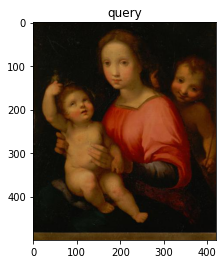

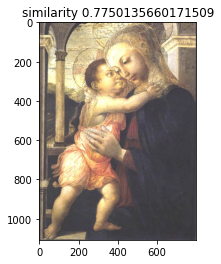

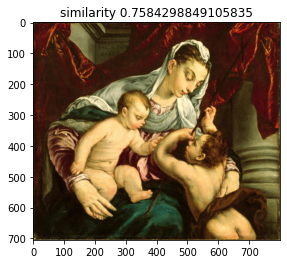

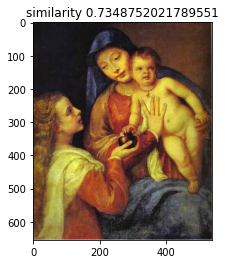

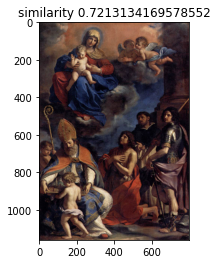

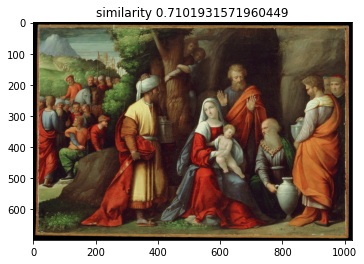

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
for k, v in uploaded.items():
  image = preprocess(to_pil_image(imageio.imread(v)[...,0:3])).unsqueeze(0)
  with torch.no_grad():
    image_feature = model.encode_image(image)
  sim = cosine_similarity(image_feature, image_embeddings)
  values, indices = torch.topk(torch.from_numpy(sim), 5)
  
  fig, axs = plt.subplots(1, 1)
  axs.imshow(imageio.imread(v)[...,0:3])
  plt.title(f"query")
  for i, index in enumerate(indices.squeeze().numpy().tolist()):
    
    fig, axs = plt.subplots(1, 1)
    axs.imshow(get_image(image_filenames[index]))
    plt.title(f"similarity {values[0,i]}")


## Suchen nach Bildern mithilfe von Textbeschreibungen



In [14]:
text = 'an image of a woman' #@param {type:"string"}

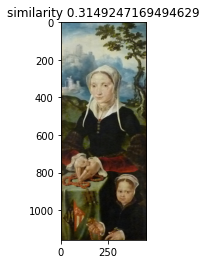

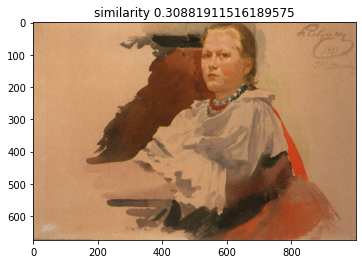

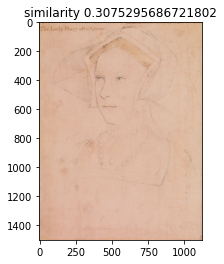

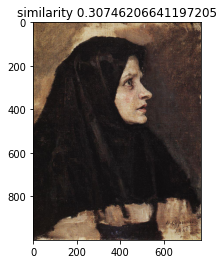

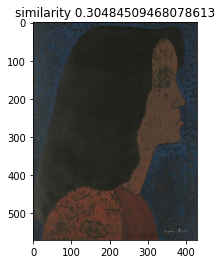

In [15]:
text = open_clip.tokenize([text])

with torch.no_grad():
    text_features = model.encode_text(text)
    
    sim = cosine_similarity(text_features, image_embeddings)
    values, indices = torch.topk(torch.from_numpy(sim), 5)
    
    for i, index in enumerate(indices.squeeze().numpy().tolist()):
      
      fig, axs = plt.subplots(1, 1)
      axs.imshow(get_image(image_filenames[index]))
      plt.title(f"similarity {values[0,i]}")
